In [1]:
include("aux_script.jl")

_exp_with_error (generic function with 1 method)

In [2]:
using Plots

In [3]:
X0 = BallInf(ones(2), 0.1)
A = [0 1; -1 0.]
δ = 0.1

orderT = 4
orderQ = 8;

In [4]:
prob = @ivp(x'=Ax, x(0) ∈ X0)
@time sol = solve(prob, alg=TMJets(orderQ=orderQ, orderT=orderT), tspan=0..0.5);

 13.777345 seconds (88.81 M allocations: 6.874 GiB, 7.77% gc time, 44.81% compilation time)


# Recursive

In [5]:
function _chen2015_recur(X0, A, δ, nsteps; orderT=2, orderQ=8)
    
    n = size(A, 1)
    C = Vector{Vector{TaylorN{IntervalArithmetic.Interval{Float64}}}}(undef, n)
    M = _exp_with_error(A, δ, order=orderT)

    R = ReachSet(X0, 0 .. 0)
    RTM0 = overapproximate(R, TaylorModelReachSet, orderQ=orderQ, orderT=orderT)
    X0_tm = set(RTM0)

    Y0 = [X.pol.coeffs[1] for X in X0_tm]
    X0 = [sum([TaylorModel1(Taylor1([TaylorN(Mi * Y0[i].coeffs) for Mi in M[j,i].coeffs]), 0..0, 0..0, 0..δ) for i in 1:n]) for j in 1:n]
    RTM1 = TaylorModelReachSet(X0, 0..δ)
    
    fpv = [RTM1] 

    for i = 2:nsteps
        X1_tm = set(fpv[end])
        X1 = [sum([(X1_tm[i].pol * M[i,j]) for j in 1:n]) for i in 1:n]
        X1v = [TaylorModel1(Taylor1(Xi.coeffs), 0..0, 0..0, 0..δ) for Xi in X1]
        RTM2 = TaylorModelReachSet(X1v, (i-1)*δ..i*δ)
        push!(fpv, RTM2)
    end
    
    return Flowpipe(fpv)
    
end

_chen2015_recur (generic function with 1 method)

# Iterative

In [6]:
function _chen2015_iter(X0, A, δ, nsteps; orderT=2, orderQ=8)
    
    n = size(A, 1)
    C = Vector{Vector{TaylorN{IntervalArithmetic.Interval{Float64}}}}(undef, n)
    
    R = ReachSet(X0, 0 .. 0)
    RTM0 = overapproximate(R, TaylorModelReachSet, orderQ=orderQ, orderT=orderT)
    X0_tm = set(RTM0)

    Y0 = [X.pol.coeffs[1] for X in X0_tm]
    
    M = _exp_with_error(A, δ, order=orderT)
    X0 = [sum([TaylorModel1(Taylor1([TaylorN(Mi * Y0[i].coeffs) 
                            for Mi in M[j,i].coeffs]), 0..0, 0..0, 0..δ) for i in 1:n]) for j in 1:n]
    RTM1 = TaylorModelReachSet(X0, 0..δ)
    
    fpv = [RTM1] 

    for i = 2:nsteps
        M = _exp_with_error(A, i*δ, order=orderT)
        X0 = [sum([TaylorModel1(Taylor1([TaylorN(Mi * Y0[i].coeffs) 
                            for Mi in M[j,i].coeffs]), 0..0, 0..0, 0..δ) for i in 1:n]) for j in 1:n]
        RTM1 = TaylorModelReachSet(X0, (i-1)*δ..i*δ)
        push!(fpv, RTM1)
    end
    
    return Flowpipe(fpv)
    
end

_chen2015_iter (generic function with 1 method)

# test

In [7]:
fp_recur = _chen2015_recur(X0, A, δ, 10);
fp_iter = _chen2015_iter(X0, A, δ, 10);

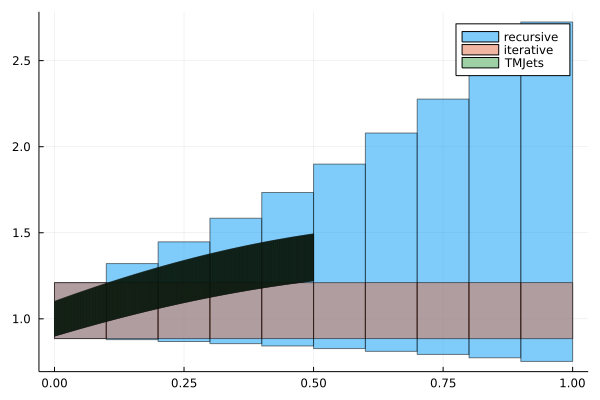

In [8]:
plot(fp_recur, vars=(0,1), lab="recursive")
plot!(fp_iter, vars=(0,1), lab="iterative")
plot!(sol, vars=(0,1), lab="TMJets")

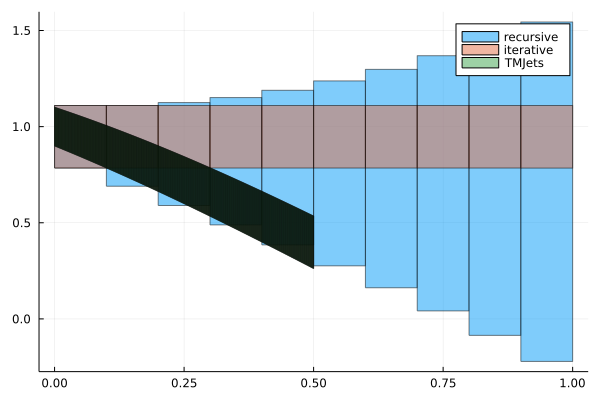

In [9]:
plot(fp_recur, vars=(0,2), lab="recursive")
plot!(fp_iter, vars=(0,2), lab="iterative")
plot!(sol, vars=(0,2), lab="TMJets")

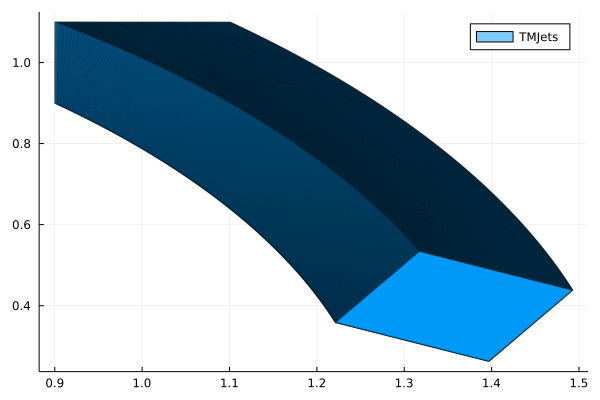

In [10]:
plot(sol, vars=(1,2), lab="TMJets")

In [11]:
plot(fp_recur, vars=(1,2), lab="recursive")

LoadError: MethodError: no method matching setrep(::Type{TaylorModelReachSet{Float64, IntervalArithmetic.Interval{Float64}}})
[0mClosest candidates are:
[0m  setrep([91m::VREP{N, AM, Val{false}, Missing}[39m) where {N, AM} at /home/daniel/.julia/dev/ReachabilityAnalysis/src/Algorithms/VREP/VREP.jl:27
[0m  setrep([91m::VREP{N, AM, Val{false}, D}[39m) where {N, AM, D} at /home/daniel/.julia/dev/ReachabilityAnalysis/src/Algorithms/VREP/VREP.jl:31
[0m  setrep([91m::VREP{N, AM, Val{true}, Missing}[39m) where {N, AM} at /home/daniel/.julia/dev/ReachabilityAnalysis/src/Algorithms/VREP/VREP.jl:35
[0m  ...

In [12]:
plot(fp_iter, vars=(1,2), lab="iterative")

LoadError: MethodError: no method matching setrep(::Type{TaylorModelReachSet{Float64, IntervalArithmetic.Interval{Float64}}})
[0mClosest candidates are:
[0m  setrep([91m::VREP{N, AM, Val{false}, Missing}[39m) where {N, AM} at /home/daniel/.julia/dev/ReachabilityAnalysis/src/Algorithms/VREP/VREP.jl:27
[0m  setrep([91m::VREP{N, AM, Val{false}, D}[39m) where {N, AM, D} at /home/daniel/.julia/dev/ReachabilityAnalysis/src/Algorithms/VREP/VREP.jl:31
[0m  setrep([91m::VREP{N, AM, Val{true}, Missing}[39m) where {N, AM} at /home/daniel/.julia/dev/ReachabilityAnalysis/src/Algorithms/VREP/VREP.jl:35
[0m  ...